# Amortized Point Estimation

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import bayesflow as bf
from bayesflow.amortizers import AmortizedPointEstimator, AmortizedPosterior
from bayesflow.benchmarks import Benchmark
from bayesflow.helper_networks import ConfigurableMLP, QuantileActivation
from bayesflow.inference_networks import InvertibleNetwork
from bayesflow.simulation import ContextGenerator, GenerativeModel, Prior, Simulator
from bayesflow.summary_networks import DeepSet

2024-04-11 02:14:08.932587: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 02:14:08.961914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 02:14:08.961945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 02:14:08.963038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 02:14:08.968340: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 02:14:08.968790: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Introduction <a class="anchor" id="introduction"></a>

In this notebook, we will demonstrate how to learn amortized neural Bayes estimators, as described in the following [paper](https://www.tandfonline.com/doi/full/10.1080/00031305.2023.2249522):

    Sainsbury-Dale, M., Zammit-Mangion, A., & Huser, R. (2024).
    Likelihood-free parameter estimation with neural Bayes estimators.
    The American Statistician, 78(1), 1-14. 

Before going into the theory and practice of neural Bayes estimators, let's start with a high level view of how this fits in and relates to BayesFlow.

We will use BayesFlow's `AmortizedPointEstimator` class. You can think of it as a drop in replacement of `AmortizedPosterior`, but there are two main differences to learning the full posterior distribution.

1. result: Instead of samples from a posterior distribution, we get a single value.

2. network: Instead of training a generative model by mapping from parameter space to latent space, with the (summarized) data as a condition, we directly map from the data to the parameter space.


For 1), we can leverage other means of uncertainty quantification, one example being bootstrapping methods as described in a later section. Additionally, we can actually go beyond estimating single valued estimators and learn a fixed-length summary of the posterior distribution. We will take a look at this as well.

For 2), we just have to choose a neural architecture with appropriate input and output dimensions for the inference network. Here, we will use a simple multilayer perceptron with residual connections in the hidden block, `ConfigurableMLP`.
Much of the appeal of neural Bayes estimators lies in how **robust and fast** it is to train this compared to a generative model.

## Theory

This overview is based on Sainsbury-Dale et al. (2024). Take a look in the paper [here](#introduction).

### Parameter Point Estimation

A parametric statistical model assigns a distribution on data space $\mathcal S$ to every parameter $\theta \in \Theta$.
Suppose we have measured data $Z \in \mathcal S$ from such a distribution. Now, the goal of parameter point estimation is to obtain an estimate of the unknown true parameter from $Z$.

$${\hat \theta} : \mathcal S \rightarrow \Theta$$


Since $Z \sim f(z|\theta)$ is stochastic, there is a range of possible values for the parameter(s) that could have generated the observed data, rather than a single, precise value.
For point estimation we need to condense the uncertainty to a single estimate. In other words, we need to choose!

Casting the estimation as a decision problem, a general choosing criteria is optimality with respect to some loss.
When we define a loss function $L(\theta, \hat \theta)$ and average it over all possible data $Z$, we obtain the estimator's *risk function* as 
$$R(\theta, \hat \theta (\cdot)) = \int_{\mathcal S} L(\theta, \hat \theta(z)) f(z|\theta) dz \, .$$ 

With this, we can single out one estimator: The so-called Bayes estimator minimizes the *Bayes risk*, which is the average of the estimator's risk function over a prior distribution $\Omega(\theta)$, 

$$r_\Omega(\hat \theta) = \int_{\mathcal \Theta} R(\theta, \hat \theta(\cdot)) d\Omega(\theta)\, .$$ 

<div class="alert alert-block alert-info"><b>What about the full posterior?</b>
<br> 
Rather than settling for a single estimate, we can approximate the full posterior distribution. How do estimators relate to the posterior? Bayes estimators are functionals of the posterior. The specific functional is determined by the choice of loss function.

More generally, one can think of the posterior density itself as optimal under a loss. The true posterior density maximizes the expected log-score, which is equivalent to minimizing the KL-divergence, see e.g. [Gneiting et al. (2007), p.7](https://doi.org/10.1198/016214506000001437).
</div>

### Useful Loss Functions and their Bayes Estimators

Different loss functions lead to different Bayes estimators.

We will go over two classes of loss functions here that cover most use cases. But don't worry, `AmortizedPointEstimator` allows you to specify your fully custom loss function just as well.

#### Normed Difference Loss

$$L(\hat \theta, \theta; k) = | \theta - \hat \theta |^k$$

Since median and mean minimize the absolute and squared distances respectively, we know that the loss results in an estimator of the posterior **median** for $k=1$ and **mean** for $k=2$.

#### Quantile Loss

$$L(\hat \theta, \theta; \tau) = (\hat \theta - \theta)(\mathbf{1}_{\hat \theta - \theta > 0} - \tau)$$

Here we write an indicator function as $\mathbf{1}_{\hat \theta - \theta > 0}$ to evaluate to 1 for overestimation (positive $\hat \theta - \theta$) and $0$ otherwise.

For $\tau=\frac 1 2$, over- or underestimating a true posterior sample $\theta$ is weighted equally. In fact, the quantile loss with $\tau=\frac 1 2$ is identical to the normed difference loss with $k=1$ (up to a scaling of $\frac 1 2$). For the same reasons, both estimate the median of the posterior.

More generally, $\tau \in (0,1)$ is the quantile level, that is the point where to evaluate the [quantile function](https://en.wikipedia.org/wiki/Quantile_function).

#### Other Loss Functions

What if you want to estimate something else? There might just be a loss function that corresponds to the estimator of exactly the quantity you are after.

The class of functions that leads to faithful estimators is called *strictly proper scoring rules*.
A good reference for the theory and examples of *strictly proper scoring rules* is the following [paper](https://doi.org/10.1198/016214506000001437).

    Gneiting, T., & Raftery, A. E. (2007). Strictly Proper Scoring Rules, Prediction, and Estimation. Journal of the American Statistical Association, 102(477), 359–378. https://doi.org/10.1198/016214506000001437


If you can find a proper scoring rule for the quantity you want to estimate, implement it as a negatively-oriented loss function and you will be able to use it within BayesFlow.

### Training Neural Bayes Estimators

We can parametrize a Bayes estimator by a neural network with parameters $\phi$ and denote it as $\hat{\theta}(\cdot;\phi)$. 
The Bayes risk can be estimated efficiently from Monte Carlo samples given by a training set of simulations.

$$r_{\Omega}(\hat{\theta}(\cdot;\phi)) \approx \frac{1}{K} \sum_{\theta \in \vartheta} \frac{1}{J} \sum_{Z \in \mathcal Z_{\theta}} L(\theta, \hat{\theta}(Z;\phi))$$

Thus, it can also be straightforwardly minimized with backpropagation and stochastic gradient decent.
Leaving aside approximation and optimization errors, **the resulting neural network minimizes the Bayes risk**. This is why we call it a neural Bayes estimator.

## Simple Benchmark from the BayesFlow Benchmark Suite: Gaussian Linear

To get familiar with the API, we start with a simple toy example with a 4-dimensional Gaussian likelihood. We use multiple observations `"n_obs"` and summarize them using a standard `DeepSet`, which outputs `summary_dim` values. The loss function can be configured in two ways. If `loss_fun` is passed, the supplied function serves as the loss. 

For this example we want to estimate the posterior mean. To do this, we use a normed difference loss of order 2.
We can define this loss function
```
def loss_fun(theta_predicted, theta_true):
    tf.norm(theta_predicted - theta_true, ord=2, axis=-1)
```
For convenience, there is a shorthand implemented in BayesFlow. Instead of passing a loss function to the `AmortizedPointEstimator`, you can specify the keyword `norm_ord` which is passed as the `ord` argument to `tf.norm`.

In [2]:
D = 4
benchmark = Benchmark("gaussian_linear", mode="posterior", prior_kwargs={"D": D}, sim_kwargs={"n_obs": 5})

summary_dim = 12

# Summarize the iid data with a DeepSet network
summary_net = DeepSet(summary_dim)

# An easy-to-use MLP with residual connections
inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=D, dropout_rate=0.0)

# The amortizer combines the inference and summary networks. We tell it to use the L2 norm with norm_ord=2.
amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=2)

INFO:root:Performing 2 pilot runs with the gaussian_linear model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 5, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Next, we have to provide a configurator, to assure that the data is first passed to the _summary network_, and not directly to the inference network

In [3]:
def config(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    # we use "summary_conditions" and not "direct_conditions" to pass the data
    # to the summary network
    input_dict["summary_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

Training can happen as usual. Here we use offline training, but online training can be used as well (see the next section for an example).

In [4]:
# Training can happen as usual
trainer = bf.trainers.Trainer(amortizer=amortizer, configurator=config)
data = benchmark.generative_model(5000)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


In [5]:
h = trainer.train_offline(data, epochs=20, batch_size=32)

Training epoch 1: 100%|█| 157/157 [00:04<00:00, 35.00it/s, Epoch: 1, Batch: 157,Loss: 
Training epoch 2: 100%|█| 157/157 [00:00<00:00, 160.29it/s, Epoch: 2, Batch: 157,Loss:
Training epoch 3: 100%|█| 157/157 [00:01<00:00, 153.14it/s, Epoch: 3, Batch: 157,Loss:
Training epoch 4: 100%|█| 157/157 [00:00<00:00, 159.56it/s, Epoch: 4, Batch: 157,Loss:
Training epoch 5: 100%|█| 157/157 [00:01<00:00, 156.63it/s, Epoch: 5, Batch: 157,Loss:
Training epoch 6: 100%|█| 157/157 [00:00<00:00, 159.04it/s, Epoch: 6, Batch: 157,Loss:
Training epoch 7: 100%|█| 157/157 [00:00<00:00, 157.10it/s, Epoch: 7, Batch: 157,Loss:
Training epoch 8: 100%|█| 157/157 [00:01<00:00, 155.67it/s, Epoch: 8, Batch: 157,Loss:
Training epoch 9: 100%|█| 157/157 [00:00<00:00, 160.45it/s, Epoch: 9, Batch: 157,Loss:
Training epoch 10: 100%|█| 157/157 [00:00<00:00, 160.37it/s, Epoch: 10, Batch: 157,Los
Training epoch 11: 100%|█| 157/157 [00:00<00:00, 159.57it/s, Epoch: 11, Batch: 157,Los
Training epoch 12: 100%|█| 157/157 [00:00<0

Finally, we can make a quick visual sanity check by plotting the estimates agains the true parameters:

In [6]:
# Generate fresh test data
test_data = benchmark.generative_model(5000)
test_data_configured = config(test_data)

# Quick (mean) point estimates can be obtained by simply calling the .estimate() method
estimates = amortizer.estimate(test_data_configured)
true_params = test_data_configured["parameters"]
estimates.shape, true_params.shape

((5000, 4), (5000, 4))

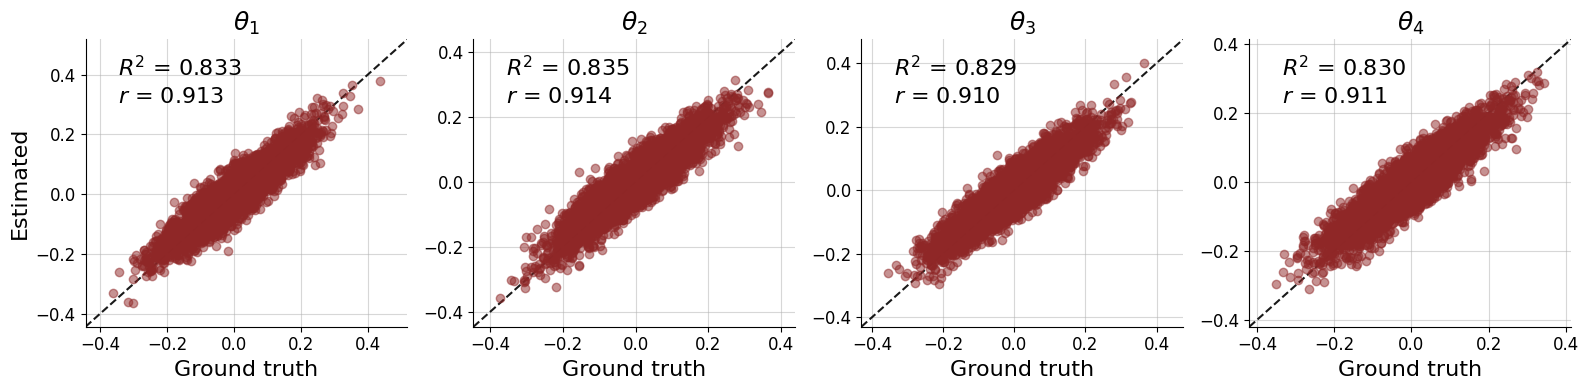

In [7]:
fig = bf.diagnostics.plot_recovery(
    estimates[:, None, :], true_params, uncertainty_agg=lambda x, *args, **kwargs: np.zeros((1, 10))
)

We can see that the recovery looks sensible. The network seems to have captured at least some information from the data. *Try to vary `n_obs` and observe how the correlations change.*

Note that the above recovery plot shows just single dots for any given dataset rather than the full posterior distribution.

Let us take this opportunity to try out the first way to get a sense of uncertainty of our neural Bayes estimator.
The idea is the following: For a specific dataset $x$, take the estimated parameter $\hat \theta (x)$ and simulate new datasets $y_i^{\hat \theta (x)} \sim \mathcal L (y|\hat \theta (x))$ with it. Now, produce a point estimate for each of those new datasets. The estimated values give you the distribution of estimates not just for the original dataset, but for *alternative likelihood draws given the original estimate*.

This is called **parametric bootstrapping** and is implemented by the bootstrap_sample() method.

In [8]:
# To quantify the uncertainty, we can use parametric bootstrapping with the .bootstrap_sample() method
estimates_bootstrap = amortizer.bootstrap_sample(
    test_data, n_bootstrap=100, simulator=benchmark.generative_model.simulator, configurator=config, to_numpy=True
)
estimates_bootstrap.shape

2024-04-11 02:14:39.197842: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1280000000 exceeds 10% of free system memory.
2024-04-11 02:14:41.777659: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1024000000 exceeds 10% of free system memory.
2024-04-11 02:14:42.049912: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1024000000 exceeds 10% of free system memory.
2024-04-11 02:14:42.281595: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1024000000 exceeds 10% of free system memory.
2024-04-11 02:14:42.513311: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1024000000 exceeds 10% of free system memory.


(5000, 100, 4)

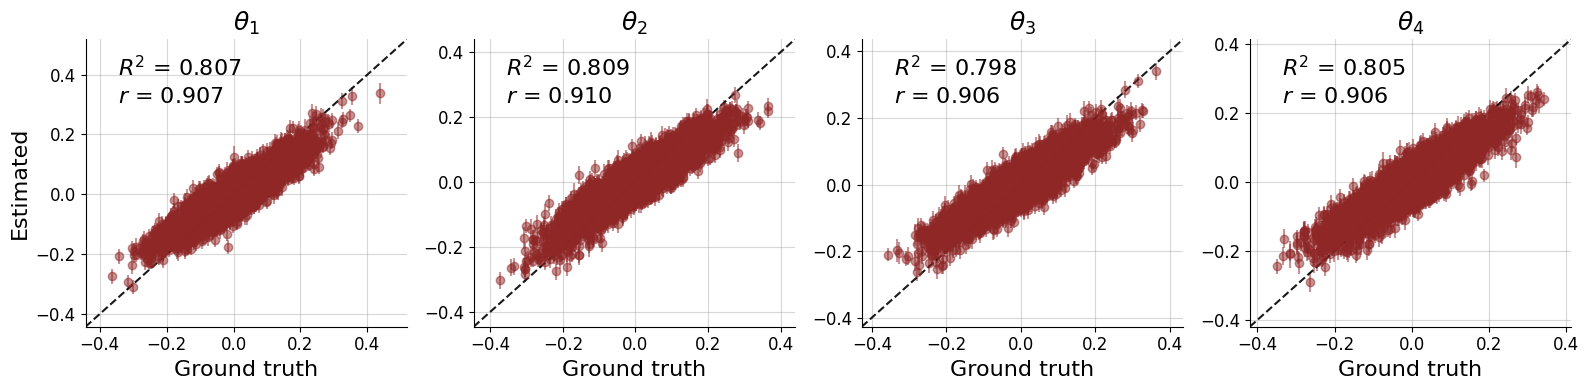

In [9]:
fig = bf.diagnostics.plot_recovery(
    estimates_bootstrap,
    true_params,
)

The parametric bootstrap distributions have reasonable recall as well. Additionally, they give us an idea how the posterior mean is influenced by randomness in the likelihood function.

Bootstrap distributions are very practical, because we get them for free and fast: no adaptations to the already trained estimator are necessary and inference is rapid because the cost is already amortized. 

On the other hand, the uncertainty estimate they provide does not in general relate to the actual posterior width or shape. Thus, we will now turn to a more sophisticated way to quantify the uncertainty using point estimators: the quantile loss.

### Quantile Estimation

To get a faithful estimation of the posterior shape, we use the strictly proper scoring rule described earlier to do quantile regression.

Since quantiles are defined on one-dimensional distributions only, they cannot straightforwardly be applied to the joint posterior  $p( (\theta_1, ... \theta_n)^T|x)$. Thus, we turn to the marginal posterior distributions $p(\theta_i|x)$ for each parameter $\theta_i$ separately.

Ideally, we want to learn multiple quantile levels $\tau \in (0,1)$ simultaneously. 
The two ingredients for this are an adapted neural architecture of the `inference_net` and a corresponding loss function.

Essentially, for each parameter the `inference_net` needs to output a quantile $q_i$ for every quantile levels $\tau_i \quad i \in 1,2,..N$ that we are interested in.
From a input batch of data with shape `(n_batch, ...)` our neural architecture shall produce output of shape `(n_batch, n_quantiles, n_params)`.

Moreover, we know that *quantiles are always ordered* since the cumulative distribution is monotonically increasing. BayesFlow comes with a handy activation function `QuantileActivation` that embodies this inductive bias.
`QuantileActivation` is meant to be the last layer in the `inference_net`. 
First, it reshapes its input from `(n_batch, n_quantiles * n_params)` to `(n_batch, n_quantiles, n_params)`.
Then, it transforms the unconstrained values to ordered outputs by cumulating over exponential functions as described in https://mc-stan.org/docs/reference-manual/transforms.html#ordered-inverse-transform.


Finally, we use a loss function that handles the vectorized quantile levels from the `inference_net`. BayesFlow ships with such a simultaneous quantile loss function.

We are free to choose any quantile levels, but we need to decide. For example, these here have a special interpretation in the Gaussian distribution:

In [10]:
quantile_levels = [0.0228, 0.1587, 0.5, 0.8413, 0.9772]

![img](https://upload.wikimedia.org/wikipedia/commons/8/8c/Standard_deviation_diagram.svg)

<a href="https://commons.wikimedia.org/wiki/User:Mwtoews">M. W. Toews</a>, <a href="https://commons.wikimedia.org/wiki/File:Standard_deviation_diagram.svg">Standard deviation diagram</a>, <a href="https://creativecommons.org/licenses/by/2.5/legalcode" rel="license">CC BY 2.5</a> 

These quantile levels correspond to standard deviation steps of a normal distribution. This means for a distribution $\mathcal N(x|\mu,\sigma^2)$ the quantile $q_1=0.0228$ is at $\mu - 2 \sigma$, the quantile $q_2=0.1587$ is at $\mu - \sigma$, the quantile $q_3=0.5$ is (not just by definition the median but also) the mean $\mu$, and so on.

We need to widen the output dimension of the inference network by the number of quantile levels and apply a `QuantileActivation` layer in the end.

The API includes a convenient access to the simultaneous quantile loss function. Simply pass the `quantile_levels` as a keyword argument to the `AmortizedPointEstimator`.

In [11]:
# Summarize the iid data with a DeepSet network
summary_net = DeepSet(summary_dim)

# An easy-to-use MLP with residual connections
inference_net = ConfigurableMLP(
    input_dim=summary_dim,
    output_dim=D * len(quantile_levels),
    dropout_rate=0.0,
    num_hidden=4,
)

# Add the quantile activation function to constrain to ordered quantiles with shape (..., n_quantiles, n_params)
inference_net = tf.keras.Sequential([inference_net, QuantileActivation(quantile_levels)])

# The amortizer combines the inference and summary networks. We tell it to use the quantile loss by passing a list to the `quantile` keyword argument.
amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, quantile_levels=quantile_levels)

This time, we supply the generative model to the `Trainer`, which enables _online_ training.

In [12]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=benchmark.generative_model, configurator=config)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [13]:
%%time
h = trainer.train_online(epochs=50, iterations_per_epoch=300, batch_size=32)

Training epoch 1: 100%|█| 300/300 [00:05<00:00, 57.18it/s, Epoch: 1, Iter: 300,Loss: 0
Training epoch 2: 100%|█| 300/300 [00:03<00:00, 98.33it/s, Epoch: 2, Iter: 300,Loss: 0
Training epoch 3: 100%|█| 300/300 [00:03<00:00, 97.19it/s, Epoch: 3, Iter: 300,Loss: 0
Training epoch 4: 100%|█| 300/300 [00:03<00:00, 97.94it/s, Epoch: 4, Iter: 300,Loss: 0
Training epoch 5: 100%|█| 300/300 [00:03<00:00, 99.69it/s, Epoch: 5, Iter: 300,Loss: 0
Training epoch 6: 100%|█| 300/300 [00:03<00:00, 97.28it/s, Epoch: 6, Iter: 300,Loss: 0
Training epoch 7: 100%|█| 300/300 [00:03<00:00, 99.60it/s, Epoch: 7, Iter: 300,Loss: 0
Training epoch 8: 100%|█| 300/300 [00:03<00:00, 98.24it/s, Epoch: 8, Iter: 300,Loss: 0
Training epoch 9: 100%|█| 300/300 [00:03<00:00, 98.83it/s, Epoch: 9, Iter: 300,Loss: 0
Training epoch 10: 100%|█| 300/300 [00:03<00:00, 98.26it/s, Epoch: 10, Iter: 300,Loss:
Training epoch 11: 100%|█| 300/300 [00:03<00:00, 92.47it/s, Epoch: 11, Iter: 300,Loss:
Training epoch 12: 100%|█| 300/300 [00:03<0

CPU times: user 13min 54s, sys: 56.9 s, total: 14min 51s
Wall time: 2min 35s


As before we do a visual sanity check by plotting the quantile estimates against the true parameters.

The neural estimator directly returns quantiles $q_1, q_2, q_3, q_4, q_5$ for the levels $\tau_1, \tau_2, \tau_3, \tau_4, \tau_5$ for each input dataset. For plotting, we condense it in two recall plots by using the median ($q_3$) as central estimate and choose as `uncertainty_agg` half the distance from the $q_2$ to $q_4$, and from the $q_1$ to $q_5$ respectively.

In [15]:
# Generate fresh test data
test_data = benchmark.generative_model(5000)
test_data_configured = config(test_data)

# Quick (quantile) point estimates can be obtained by simply calling the .estimate() method
estimates = amortizer.estimate(test_data_configured)
true_params = test_data_configured["parameters"]
estimates.shape, true_params.shape

((5000, 5, 4), (5000, 4))

In [16]:
median = estimates[:, 2, :]
two_sigma_halfwidth = np.abs(estimates[:, 4, :] - estimates[:, 0, :]) / 2
one_sigma_halfwidth = np.abs(estimates[:, 3, :] - estimates[:, 1, :]) / 2

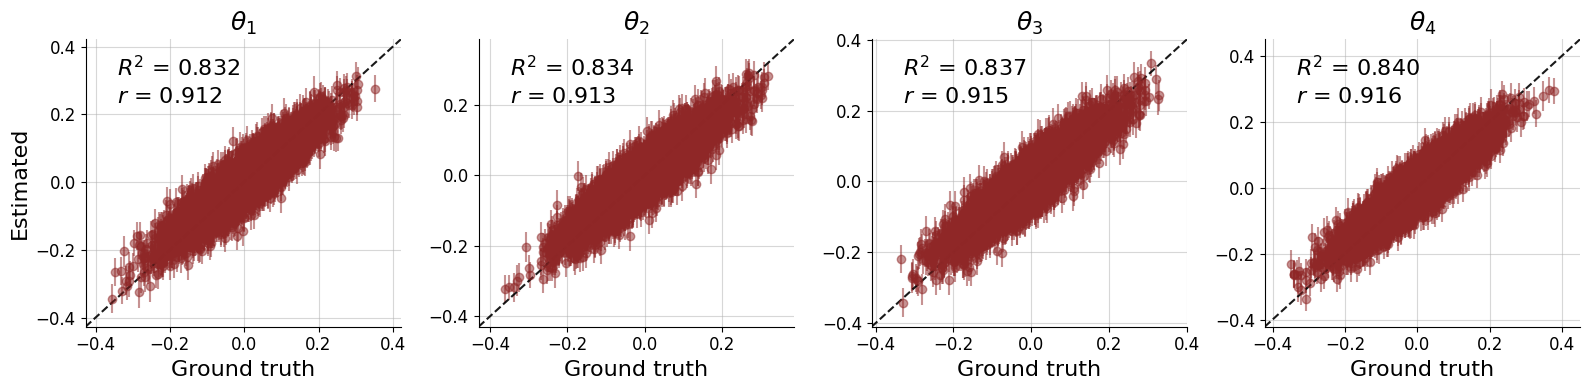

In [17]:
fig = bf.diagnostics.plot_recovery(
    median[:, None, :],
    true_params,
    uncertainty_agg=lambda x, *args, **kwargs: one_sigma_halfwidth[np.where(np.all(x[:, 0] == median, axis=1))[0], :],
)

The recall seems sensible...

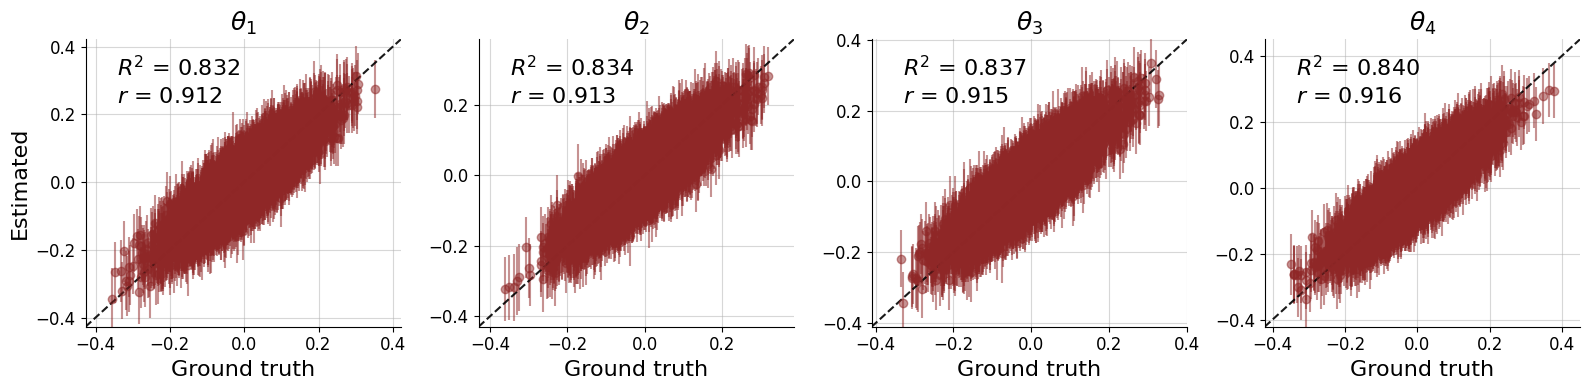

In [18]:
fig = bf.diagnostics.plot_recovery(
    median[:, None, :],
    true_params,
    uncertainty_agg=lambda x, *args, **kwargs: two_sigma_halfwidth[np.where(np.all(x[:, 0] == median, axis=1))[0], :],
)

... and the uncertainty looks promising as well. The vertical bars of the second plot, which shows the larger *quantile level* interval ($\tau_5-\tau_1$), are actually taller, i.e. the *quantile* distance ($q_5-q_1$) is bigger, compared to the above plot with the smaller *quantile level* interval ($\tau_4-\tau_2$).

### Simulation-based Calibration Diagnosic for Quantiles

How well does the predictive distribution implied by the quantiles match the true statistics of the posterior?
For example, is it reliably true that in 15% of cases the true parameters lie below the 15% quantile?  

Let us take a look.
We can calculate the frequency of cases where the true parameter $\theta_i$ happens to be lower than a quantile estimate $q_{ji}$ for that parameter. Another way to think about these frequencies is to evaluate the empirical cumulative distribution function (ECDF) at the estimated quantiles. If the quantile estimator faithfully captures the true posterior quantiles, the ECDF evaluated at the quantiles should asymptotically tend to the corresponding quantile levels.

We turn this into a visual calibration diagnostic similar to the one employed for full posterior learning using `plot_sbc_ecdf()`. We plot the difference of the ECDF, evaluated at the quantiles, minus the corresponding quantile levels.

In [19]:
from scipy.stats import binom


def consistency_bounds(quantile_levels, n, confidence=0.95):
    alpha = 1 - confidence
    lower = np.zeros_like(quantile_levels)
    upper = np.zeros_like(quantile_levels)

    for i, p in enumerate(quantile_levels):
        lower[i] = binom.ppf(alpha / 2, n, p) / n
        upper[i] = binom.ppf(1 - alpha / 2, n, p) / n

    return lower, upper

In [20]:
import warnings

warnings.filterwarnings("ignore", "use_inf_as_na")

Text(0, 0.5, 'Empirical quantile level deviation')

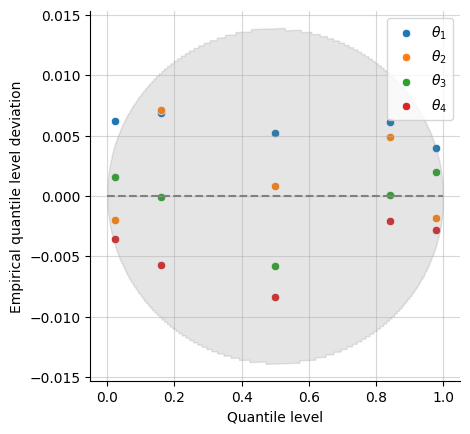

In [21]:
estimate_above_true = np.mean(estimates[:, :, :] > true_params[:, np.newaxis, :], axis=0)

sns.lineplot(x=[0, 1], y=[0, 0], color="grey", linestyle="--")
for i in range(D):
    sns.scatterplot(x=quantile_levels, y=estimate_above_true[:, i] - quantile_levels, label=rf"$\theta_{i+1}$")

eps = 0.001
z = np.linspace(0 + eps, 1 - eps, 1000)
upper, lower = consistency_bounds(z, estimates.shape[0], confidence=0.95)

plt.fill_between(z, lower - z, upper - z, color="gray", alpha=0.2, label=rf"{int((1-0.05) * 100)}$\%$ Confidence Bands")

sns.despine(ax=plt.gca())
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())

plt.grid(alpha=0.5)
plt.xlabel("Quantile level")
plt.ylabel("Empirical quantile level deviation")

The shaded area shows the statistical fluctuation we can expect from having only a finite number of samples. Using more samples will lead to less finite-sampling fluctuations and a tighter consistency interval. If the quantile estimator is in fact calibrated, 95% of datasets from the generative model lead to (individual) empirical quantile level deviations inside the shaded area.

*Try generating fresh test data a few times and see how the empirical quantile level deviation changes.* Is our quantile estimator calibrated?

### Comparison to True Posterior Density

To conclude the exploration of quantile estimation, we can plot the the quantiles on top of the true posterior density. The posterior is available in closed form and we can write functions to sample from it:

In [22]:
def get_true_posterior_mean_and_std(sim_data, prior_scale, sim_scale):

    N = sim_data.shape[1]
    sample_mean = np.mean(sim_data, axis=1)  # (batch_size, num_params)

    b = prior_scale ** (2) + sim_scale ** (2) / N

    post_mean = sample_mean * prior_scale**2 / b
    post_scale = prior_scale * sim_scale / np.sqrt(b * N)

    return post_mean, post_scale


def sample_posterior(sim_data, prior_scale, sim_scale, n_samples):

    # Calculate mean and std of the posterior distribution
    post_mean, post_scale = get_true_posterior_mean_and_std(sim_data, prior_scale, sim_scale)

    # Draw samples from the posterior distribution
    samples = np.random.normal(
        loc=post_mean[:, None, :], scale=post_scale, size=(sim_data.shape[0], n_samples, sim_data.shape[2])
    )

    return samples

We simulate a dataset we could have observed and prepare prior and posterior samples for plotting. Then, we also estimate the quantiles with the trained `AmortizedPointEstimator`.

In [23]:
forward_dict = benchmark.generative_model(1)

x_obs = forward_dict["sim_data"]

prior_draws = benchmark.generative_model.prior(10000)["prior_draws"]
post_samples = sample_posterior(x_obs, prior_scale=0.1, sim_scale=0.1, n_samples=10000)[0]

In [24]:
estimate_obs = amortizer.estimate(config(forward_dict))[0]
estimate_obs.shape

(5, 4)

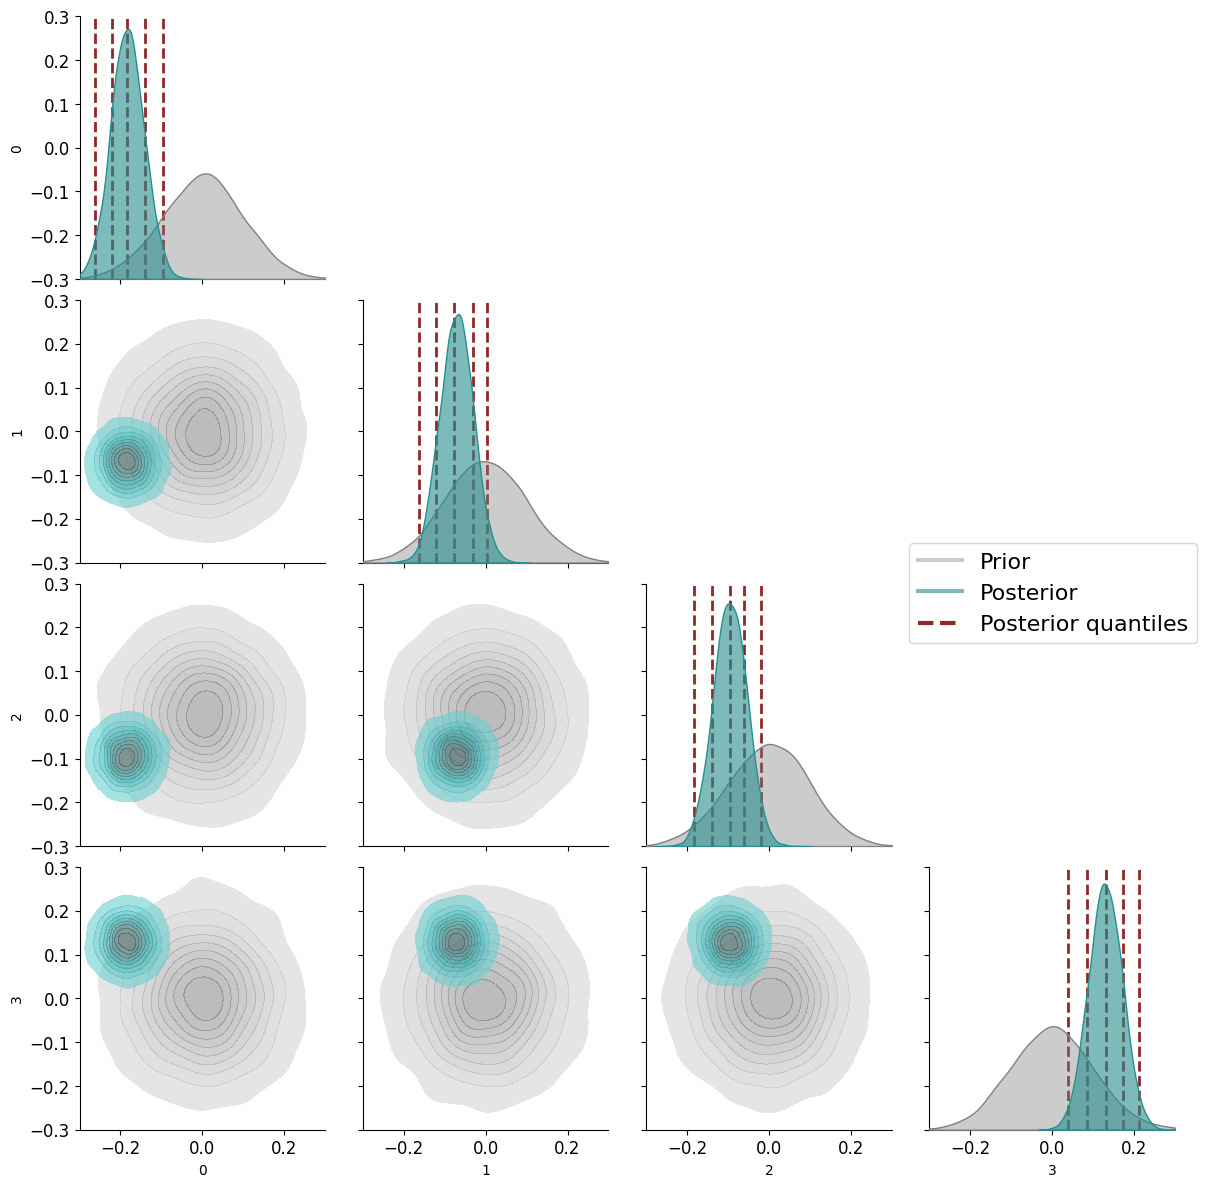

In [25]:
tick_fontsize = 12
legend_fontsize = 16
quantile_color = "#8f2727"
post_color = "#278f8f"
prior_color = "gray"
post_alpha = 0.6
prior_alpha = 0.4

bw_adjust = 1.3

posterior_draws_df = pd.DataFrame(post_samples)
g = sns.PairGrid(posterior_draws_df, height=3)
g.map_diag(sns.kdeplot, bw_adjust=bw_adjust, color=post_color, alpha=post_alpha, fill=True)
g.map_lower(sns.kdeplot, bw_adjust=bw_adjust, color=post_color, alpha=post_alpha, fill=True)

prior_draws_df = pd.DataFrame(prior_draws)
g.data = prior_draws_df
g.map_diag(sns.kdeplot, bw_adjust=bw_adjust, color=prior_color, alpha=prior_alpha, fill=True, zorder=-1)
g.map_lower(sns.kdeplot, bw_adjust=bw_adjust, color=prior_color, alpha=prior_alpha, fill=True, zorder=-1)

n_quantiles = len(quantile_levels)

# Mark estimators
for j in range(posterior_draws_df.shape[1]):
    ax = g.axes[j, j]

    for q in range(n_quantiles):
        ax.axvline(x=estimate_obs[q, j], color=quantile_color, linewidth=2, linestyle="--", zorder=10)


# Remove upper axis
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].axis("off")

# Modify tick sizes
for i, j in zip(*np.tril_indices_from(g.axes, 1)):
    g.axes[i, j].tick_params(axis="both", which="major", labelsize=tick_fontsize)
    g.axes[i, j].tick_params(axis="both", which="minor", labelsize=tick_fontsize)

g.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3))

# Add legend
from matplotlib.lines import Line2D

handles = [
    Line2D(xdata=[], ydata=[], color=prior_color, lw=3, alpha=prior_alpha),
    Line2D(xdata=[], ydata=[], color=post_color, lw=3, alpha=post_alpha),
    Line2D(xdata=[], ydata=[], color=quantile_color, lw=3, linestyle="--", alpha=1),
]
g.figure.legend(handles, ["Prior", "Posterior", "Posterior quantiles"], fontsize=legend_fontsize, loc="center right");

The quantiles span the true posterior quite well. What else can we say?

For this benchmark problem the true posterior is a Gaussian distribution. Therefore, two things must be true:
First, the maximum a posteriori (MAP) point (peak of the posterior distribution) and the posterior's median (central quantile) should the same.
Second, the quantiles we chose have a special meaning in Gaussian distributions: They are equidistant steps, all separated by one standard deviation.

As far as visual inspection goes, this seems to be approximately true for our trained quantile estimator, thus we can call it an (approximate) neural Bayes estimator. Yay! 🥳

## Illustrative Example from Sainsbury-Dale et al.

In section 2.2.3 of the paper, a simple one-dimensional example is given as a demonstration and sanity check. Here, we want to replicate the main result, namely that the learned amortized Bayes estimator closely resembles the analytical one. Please refer to the paper for background and formulas.

First, we specify out generative model. The prior is a Pareto distribution with $\alpha=4$ and $\beta=1$. The likelihood is a uniform distribution, with a minimum value of zero and a maximum value which is determined by the parameter $\theta$. For efficiency, we create a _batched_ simulator, i.e. we generate a whole batch of data in one function call.

In [26]:
def batch_prior_fun(batch_size):
    dist = tfp.distributions.Pareto(4.0, 1.0)
    return dist.sample((batch_size, 1))


def batch_simulator_fun(theta, n_obs=10):
    return tf.random.uniform((theta.shape[0], 10), maxval=theta)[:, :, None]


prior = Prior(batch_prior_fun=batch_prior_fun)
simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Again, we specify a summary network. As the dimensionality is lower (1) this time, a smaller number of summary dimensions should be sufficient. We use `norm_ord=1`, i.e. an absolute-error loss, to obtain the posterior median, as required in this example.

In [27]:
summary_dim = 5
summary_net = DeepSet(summary_dim)

inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=1, dropout_rate=0.0)

amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=1)

The configurator is similar to the one above, but we skip the `.astype` calls, as the generative model already produces TensorFlow tensors.

In [28]:
def config(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"]
    # we use "summary_conditions" and not "direct_conditions" to pass the data
    # to the summary network
    input_dict["summary_conditions"] = forward_dict["sim_data"]
    return input_dict

We again supply the generative model to the `Trainer`, which enables _online_ training.

In [29]:
trainer = bf.trainers.Trainer(amortizer=amortizer, configurator=config, generative_model=generative_model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [30]:
%%time
h = trainer.train_online(50, 200, batch_size=32)

Training epoch 1: 100%|█| 200/200 [00:03<00:00, 50.88it/s, Epoch: 1, Iter: 200,Loss: 0
Training epoch 2: 100%|█| 200/200 [00:02<00:00, 99.93it/s, Epoch: 2, Iter: 200,Loss: 0
Training epoch 3: 100%|█| 200/200 [00:02<00:00, 98.24it/s, Epoch: 3, Iter: 200,Loss: 0
Training epoch 4: 100%|█| 200/200 [00:02<00:00, 96.56it/s, Epoch: 4, Iter: 200,Loss: 0
Training epoch 5: 100%|█| 200/200 [00:02<00:00, 98.84it/s, Epoch: 5, Iter: 200,Loss: 0
Training epoch 6: 100%|█| 200/200 [00:02<00:00, 99.43it/s, Epoch: 6, Iter: 200,Loss: 0
Training epoch 7: 100%|█| 200/200 [00:02<00:00, 98.64it/s, Epoch: 7, Iter: 200,Loss: 0
Training epoch 8: 100%|█| 200/200 [00:02<00:00, 95.53it/s, Epoch: 8, Iter: 200,Loss: 0
Training epoch 9: 100%|█| 200/200 [00:02<00:00, 96.80it/s, Epoch: 9, Iter: 200,Loss: 0
Training epoch 10: 100%|█| 200/200 [00:02<00:00, 97.40it/s, Epoch: 10, Iter: 200,Loss:
Training epoch 11: 100%|█| 200/200 [00:02<00:00, 99.84it/s, Epoch: 11, Iter: 200,Loss:
Training epoch 12: 100%|█| 200/200 [00:02<0

CPU times: user 4min 51s, sys: 22.2 s, total: 5min 13s
Wall time: 1min 44s


To test the estimator, we generate data with a fixed parameter $\theta=4/3$. To keep the code as simple as possible, we just modify the prior of the simulator to only return the desired theta:

In [31]:
# Quick point estimates can be obtained by simply calling the .estimate() method
num_test = 30_000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 4 / 3  # set theta to 4/3 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Using the amortizers `estimate` method, we can obtain the estimate for each data set.

In [32]:
%%time
estimates = amortizer.estimate(test_data)[:, 0]

CPU times: user 3.3 s, sys: 4.23 s, total: 7.53 s
Wall time: 986 ms


For comparison, we calculate the values with the analytic Bayes estimator as well:

In [33]:
def bayes_estimator(Z, alpha=4, beta=1):
    m = Z.shape[-2]
    max_vals = np.max(Z, axis=-2)
    return np.power(2, 1 / (alpha + m)) * np.maximum(max_vals, beta)


reference = bayes_estimator(test_data["summary_conditions"])[:, 0]

Finally, we compare both the kernel density estimate of the estimators distribution and the correlation between analytical and estimated values:

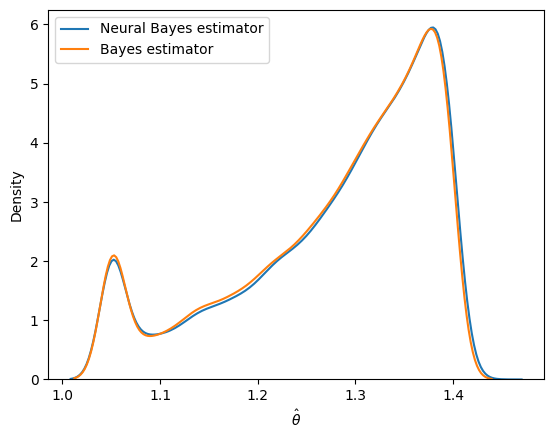

In [34]:
sns.kdeplot(estimates, label="Neural Bayes estimator")
sns.kdeplot(reference, label="Bayes estimator")
plt.xlabel(r"$\hat\theta$")
_ = plt.legend()

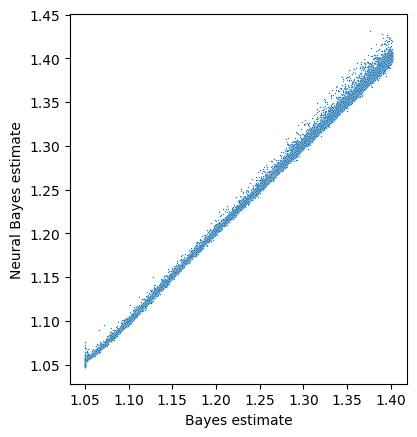

In [35]:
sns.scatterplot(x=reference, y=estimates, s=1)
plt.gca().set_aspect("equal")
plt.xlabel("Bayes estimate")
_ = plt.ylabel("Neural Bayes estimate")